## Note
For this file to run successfully, it is necessary to have already trained H1. This file loads in the trained version of H1 to initialise the weights of the H2 model.

Much of the code used to implement federated learning is taken or adapted from https://www.tensorflow.org/federated/tutorials/building_your_own_federated_learning_algorithm

## Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Individual Models FXAI/

/content/drive/MyDrive/Individual Models FXAI


## Env setup

In [3]:
!pip install --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.4/114.4 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.6/104.6 kB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 558.5/558.5 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 MB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 255.8/255.8 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 kB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

# Training H2

## Imports

In [4]:
from __future__ import print_function

import tensorflow as tf
import tensorflow_federated as tff
import numpy as np
import collections
from tensorflow.keras.models import load_model

# From EHIL


import keras
from keras.layers.convolutional import ( Conv2D, MaxPooling2D, AveragePooling2D)
from keras.layers import (    Input,    Activation,    Dense,    Flatten)
from keras.layers import add
from keras.layers import LayerNormalization

from keras.regularizers import l2
from keras import backend as K
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.utils import np_utils

import os
import numpy as np

from sklearn.model_selection import train_test_split

import time
import datetime

import csv

## Config

In [5]:
img_channels = 3
BATCH_SIZE = 20
NUM_CLIENTS = 25 # 25
STATE_CLASSES = 10
EPOCHS = 500
LOGS_DIR = 'H2'
MODEL_NAME = 'h2_25_clients_500_epochs'
H1_MODEL_NAME = 'h1_25_clients_200_epochs'

##############################################################################

img_rows, img_cols = 256,256
img_rows, img_cols = 50,50

Cup_Type = 'Big'
if Cup_Type == 'Medium':
    nb_classes = 9
if Cup_Type == 'Big':
    nb_classes = 10
if Cup_Type == 'Small':
    nb_classes = 7


## Load Data

In [6]:
NPZ_Name = 'Data/Videos_Database_20_Robot_WebCam_50_overall_database.npz'
Database_Used = np.load(NPZ_Name)
Sessions = Database_Used['Session']
X_train = Database_Used['X_train']

In [7]:
# create a list of the unique sessions
client_ids = np.unique(Sessions)

In [8]:
# Several steps need to be completed to convert our data to a format suitable for tensorflow-federated operations
# The first is to create tf.data.Dataset objects
def create_tf_dataset(client_ids, Database_used_col, categorical, categories):
  train_datasets = []
  test_datasets = []
  for session in client_ids:
    # find the indices of the current session in the Sessions column of Database_Used
    session_indices = np.where(Sessions == session)[0]

    # get the X_train data for the current session
    session_X = Database_Used['X_train'][session_indices]
    # grab the training data for the necessary hierarchy
    session_Y = Database_Used[Database_used_col][session_indices]
    # if using categorical data, reshape the data for the model into one-hot encoded
    if categorical==True:
      session_Y = np_utils.to_categorical(session_Y, categories)
    # create train/test split
    X_train, X_test, Y_train, Y_test = train_test_split(session_X, session_Y, test_size=0.2, random_state=100)
    # Make into tf dataset
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
    # Add to our list of datasets
    train_datasets.append([session,train_dataset])
    test_datasets.append([session,test_dataset])
  return train_datasets, test_datasets

In [9]:
state_train_datasets, state_test_datasets = create_tf_dataset(client_ids, 'Y_train_State', True, STATE_CLASSES)

In [10]:
def make_client_data(datasets):
  client_data = {}
  # loop through the datasets
  for dataset in datasets:
      # get the session name
      session = dataset[0]

      # get the session data
      session_data = dataset[1]

      # add the session data to the client_data dictionary
      client_data[session] = session_data
  return client_data

In [11]:
# Make everything into a map for creating ClientData objects necessary for TFF federated learning

state_train_client_data = make_client_data(state_train_datasets)
state_test_client_data = make_client_data(state_test_datasets)

In [12]:
client_ids = list(client_ids)

## Setup Federated Data

In [13]:
def make_federated_data(client_data, client_ids):
  # Need a function to get the client data in order to make ClientData object
  def get_client_dataset(client_id):
    return client_data[client_id]

  # use tff to create ClientData object from our training data
  federated_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(client_ids, get_client_dataset)

  return federated_data

In [14]:
state_train_federated_data = make_federated_data(state_train_client_data, client_ids)
state_test_federated_data = make_federated_data(state_test_client_data, client_ids)

In [15]:

def preprocess(dataset, num_classes):
    def batch_format_fn(image, label):
        """Prepare a batch of data and return a (features, label) tuple."""
        batch_size = tf.shape(image)[0]  # Get the current batch size
        return (tf.reshape(image, [batch_size, 50, 50, 3]),
                tf.reshape(label, [batch_size, num_classes]))

    return dataset.batch(BATCH_SIZE).map(batch_format_fn)

def preprocess_federated_data(federated_data, num_classes):
  client_ids = sorted(federated_data.client_ids)[:NUM_CLIENTS]
  federated_data = [preprocess(federated_data.create_tf_dataset_for_client(x), num_classes)
                          for x in client_ids]
  return federated_data



In [16]:
state_train = preprocess_federated_data(state_train_federated_data, STATE_CLASSES)

In [17]:
state_train[0].element_spec

(TensorSpec(shape=(None, 50, 50, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))

## Setup Model

### Functions from Dandan's Code

In [18]:
###############################################################################
'''
Functions
'''
###############################################################################

from keras.initializers import glorot_uniform

def lr_schedule(epoch):
    '''
    epoch: number of epochs for model training
    lr: learning rate
    '''
    lr = 1e-3
    if epoch > 160:
        lr *= 0.5e-3
    elif epoch > 120:
        lr *= 1e-3
    elif epoch > 80:
        lr *= 1e-2
    elif epoch > 40:
        lr *= 1e-1
    print('Learning rate: ', lr)
    return lr



def Conv_bn_relu(infor, **conv_params):
    '''
    Build conv -> BN -> relu block
    '''
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))


    conv = Conv2D(filters=filters, kernel_size=kernel_size,
                  strides=strides, padding=padding,
                  kernel_initializer=kernel_initializer,
                  kernel_regularizer=kernel_regularizer)(infor)


    norm = LayerNormalization(axis=CHANNEL_AXIS)(conv)
    out = Activation("relu")(norm)

    return out


#Reference: http://arxiv.org/pdf/1603.05027v2.pdf
def Bn_relu_conv(infor,**conv_params):
    '''
    Build a BN -> relu -> conv block.
    '''
    filters = conv_params["filters"]
    kernel_size = conv_params["kernel_size"]
    strides = conv_params.setdefault("strides", (1, 1))
    kernel_initializer = conv_params.setdefault("kernel_initializer", "he_normal")
    padding = conv_params.setdefault("padding", "same")
    kernel_regularizer = conv_params.setdefault("kernel_regularizer", l2(1.e-4))

    norm = LayerNormalization(axis=CHANNEL_AXIS)(infor)

    activation = Activation("relu")(norm)

    out = Conv2D(filters=filters, kernel_size=kernel_size,
                      strides=strides, padding=padding,
                      kernel_initializer=kernel_initializer,
                      kernel_regularizer=kernel_regularizer)(activation)

    return out



def basic_block(BlockIn, filters, init_strides=(1, 1), is_first_block_of_first_layer=False):
    '''
    Basic 3 X 3 convolution blocks
    '''

    if is_first_block_of_first_layer:
        conv1 = Conv2D(filters=filters, kernel_size=(3, 3),
                       strides=init_strides,
                       padding="same",
                       kernel_initializer="he_normal",
                       kernel_regularizer=l2(1e-4))(BlockIn)
    else:
        conv1 = Bn_relu_conv(infor = BlockIn,filters=filters, kernel_size=(3, 3),
                              strides=init_strides)

    residual = Bn_relu_conv(infor = conv1,filters=filters, kernel_size=(3, 3))


    input_shape = K.int_shape(BlockIn)
    residual_shape = K.int_shape(residual)

    # stride should be set properly and match  (width, height) of residual
    stride_width = int(round(input_shape[ROW_AXIS] / residual_shape[ROW_AXIS]))
    stride_height = int(round(input_shape[COL_AXIS] / residual_shape[COL_AXIS]))


    equal_channels = input_shape[CHANNEL_AXIS] == residual_shape[CHANNEL_AXIS]


    if stride_width > 1 or stride_height > 1 or not equal_channels:
        shortcut = Conv2D(filters=residual_shape[CHANNEL_AXIS],
                          kernel_size=(1, 1),
                          strides=(stride_width, stride_height),
                          padding="valid",
                          kernel_initializer="he_normal",
                          kernel_regularizer=l2(0.0001))(BlockIn)
    else:
        shortcut = BlockIn

    # Adds a shortcut between input and residual block
    return add([shortcut, residual])


def buildmodel(input_shape, num_outputs, Regress_Flag):
        '''

        input_shape: (nb_channels, nb_rows, nb_cols)
        num_outputs:  number of outputs at final softmax layer
        Regress_Flag: classify or regress

        '''

        global ROW_AXIS
        global COL_AXIS
        global CHANNEL_AXIS

        # if K.image_data_format() == 'channels_last':

        #     ROW_AXIS = 1; COL_AXIS = 2;  CHANNEL_AXIS = 3
        # else:
        #     CHANNEL_AXIS = 1; ROW_AXIS = 2; COL_AXIS = 3

        if tf.keras.backend.image_data_format() == 'channels_last':
            ROW_AXIS = 1
            COL_AXIS = 2
            CHANNEL_AXIS = 3
        else:
            CHANNEL_AXIS = 1
            ROW_AXIS = 2
            COL_AXIS = 3



        if len(input_shape) != 3:
            raise Exception("Input shape should be a tuple (nb_channels, nb_rows, nb_cols)")

        # Permute dimension order if necessary
        if K.image_data_format() == 'channels_last':
        #if K.image_dim_ordering() == 'tf':

            input_shape = (input_shape[1], input_shape[2], input_shape[0])

        input = Input(shape=input_shape, name='main_input')
        conv1 = Conv_bn_relu(input, filters=64, kernel_size=(7, 7), strides=(2, 2))
        pool1 = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), padding="same", name = "conv_pool1")(conv1)

        block = pool1
        filters = 64
        for i, r in enumerate([2,2,2,2]):
            '''
            residual block with repeating bottleneck blocks
            '''

            is_first_layer=(i == 0)
            for i in range(r):
                init_strides = (1, 1)
                if i == 0 and not is_first_layer:
                    init_strides = (2, 2)
                block = basic_block(BlockIn = block, filters=filters, init_strides=init_strides,
                                       is_first_block_of_first_layer=(is_first_layer and i == 0))

            filters *= 2

        # Last activation

        norm = LayerNormalization(axis=CHANNEL_AXIS)(block)
        block = Activation("relu")(norm)

        # classifier block
        block_shape = K.int_shape(block)
        pool2_out = AveragePooling2D(pool_size=(block_shape[ROW_AXIS], block_shape[COL_AXIS]),
                                 strides=(1, 1), name = "conv_final")(block)

        #flatten1 = keras.layers.GlobalAveragePooling2D(name = "GAP")(pool2)
        #out = keras.layers.Dense(num_outputs,activation='softmax')(pooled)

        flatten1 = Flatten( name = "Flatten")(pool2_out)

        flatten1 = Dense(128, activation='relu',name = "Flatten2")(flatten1)

        if Regress_Flag == False:

            dense = Dense(units=num_outputs, kernel_initializer="he_normal",
                      activation="softmax", name = "Dense_layer")(flatten1)
        else:
            dense = Dense(units=1, activation='linear', kernel_initializer=glorot_uniform(seed=0))(flatten1)

            #dense = Dense(units=1, kernel_initializer="he_normal", activation="linear", name = "Dense_layer")(flatten1)

        model = Model(inputs=input, outputs=dense)
        return model


def learn_model(oldmodel,nb_classes,Transfer_Type,summary=False):

    base_model = oldmodel

    if Transfer_Type == 'Classification':
        intermediate_layer_model = Model(inputs=base_model.input,outputs=base_model.get_layer("conv_final").output)

    if Transfer_Type == 'Regression':
        #intermediate_layer_model = Model(inputs=base_model.input,outputs=base_model.get_layer("Flatten1").output)
        intermediate_layer_model = Model(inputs=base_model.input,outputs=base_model.get_layer("Dense_Classification").output)

    x = intermediate_layer_model(base_model.input)
    if nb_classes >1:
        x = keras.layers.GlobalAveragePooling2D()(x)# 添加全局平均池化层
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)


    if Transfer_Type == 'Classification':
        dense = Dense(units=nb_classes, kernel_initializer="he_normal",
                  activation="softmax", name = "Dense_Classification")(x)
    if Transfer_Type == 'Regression':
        dense = Dense(units=1, activation='linear', name = "Dense_Regression", kernel_initializer=glorot_uniform(seed=0))(x)

    model = Model(inputs=base_model.input, outputs=dense)


    # show summary if specified
    if summary==True :
        model.summary()

    if Transfer_Type == 'Classification':
        # choose the optimizer
        #optimizer = keras.optimizers.Adam()
        model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    if Transfer_Type == 'Regression':
        model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=['mse'])

    return model


### Load From H1 Model

In [19]:
# We need the model weights from training H1 to initialise the H2 model
h1_model = keras.models.load_model('Models/' + H1_MODEL_NAME + '.h5')
model = learn_model(h1_model,STATE_CLASSES,'Classification',summary=False)

# It makes the implementation simpler to remove any arguments from the model building function
def build_h2_model():
  return keras.models.clone_model(model)


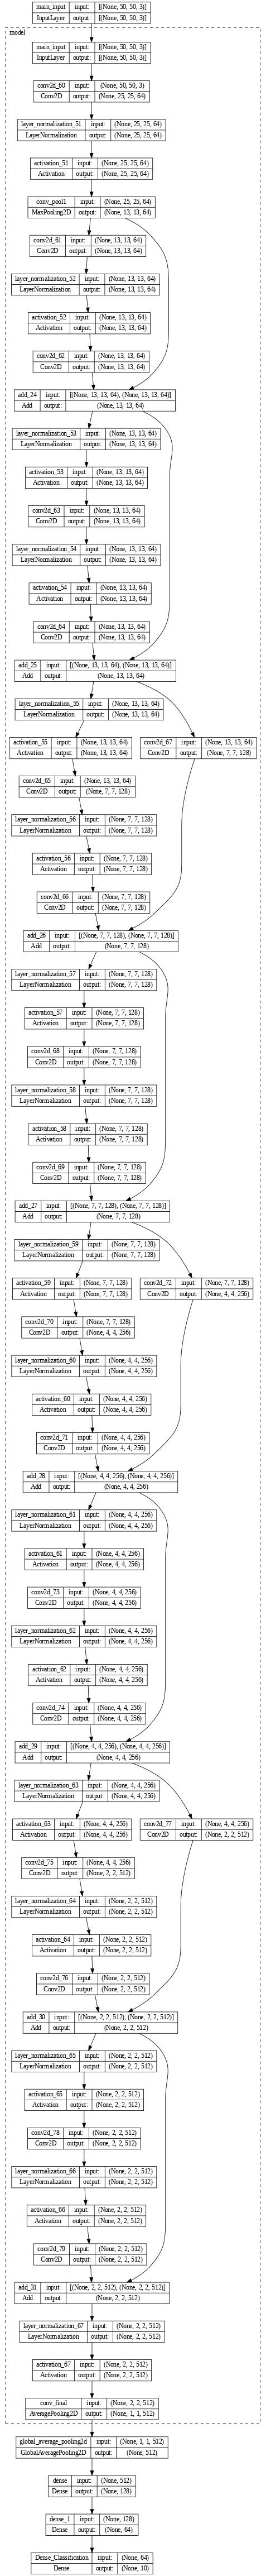

In [20]:
# View the model architecture
model = build_h2_model()
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [21]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 main_input (InputLayer)     [(None, 50, 50, 3)]       0         
                                                                 
 model (Functional)          (None, 1, 1, 512)         11179520  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 Dense_Classification (Dense  (None, 10)               650       
 )                                                         

## Setup Federated Learning

In [22]:
def model_fn_h2():
  model = build_h2_model()
  return tff.learning.models.from_keras_model(
      model,
      input_spec=state_train[0].element_spec,
      loss=tf.keras.losses.CategoricalCrossentropy(),
      metrics=[tf.keras.metrics.Accuracy()])

In [23]:
@tff.tf_computation
def server_init_h2():
  model = model_fn_h2()
  return model.trainable_variables

In [24]:
@tff.federated_computation
def initialize_fn_h2():
  return tff.federated_value(server_init_h2(), tff.SERVER)

In [25]:
@tf.function
def client_update_h2(model, dataset, server_weights, client_optimizer):
  """Performs training (using the server model weights) on the client's dataset."""
  # Initialize the client model with the current server weights.
  client_weights = model.trainable_variables
  # Assign the server weights to the client model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        client_weights, server_weights)

  # Use the client_optimizer to update the local model.
  for batch in dataset:
    with tf.GradientTape() as tape:
      # Compute a forward pass on the batch of data
      outputs = model.forward_pass(batch)

    # Compute the corresponding gradient
    grads = tape.gradient(outputs.loss, client_weights)
    grads_and_vars = zip(grads, client_weights)

    # Apply the gradient using a client optimizer.
    client_optimizer.apply_gradients(grads_and_vars)

  return client_weights

In [26]:
@tf.function
def server_update_h2(model, mean_client_weights):
  """Updates the server model weights as the average of the client model weights."""
  model_weights = model.trainable_variables
  # Assign the mean client weights to the server model.
  tf.nest.map_structure(lambda x, y: x.assign(y),
                        model_weights, mean_client_weights)
  return model_weights

In [27]:
h2_fed = model_fn_h2()
tf_dataset_type_h2 = tff.SequenceType(h2_fed.input_spec)

In [28]:
str(tf_dataset_type_h2)

'<float32[?,50,50,3],float32[?,10]>*'

In [29]:
model_weights_type_h2 = h2_fed.trainable_variables
# Assuming model_weights_type is a list of trainable variables
model_weights_type_h2 = [v for v in model_weights_type_h2]

model_weights_type_h2 = tff.to_type([tf.TensorSpec.from_tensor(v.value()) for v in model_weights_type_h2])

In [30]:
@tff.tf_computation(tf_dataset_type_h2, model_weights_type_h2)
def client_update_fn_h2(tf_dataset, server_weights):
  model = model_fn_h2()
  client_optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
  return client_update_h2(model, tf_dataset, server_weights, client_optimizer)

In [31]:
@tff.tf_computation(model_weights_type_h2)
def server_update_fn_h2(mean_client_weights):
  model = model_fn_h2()
  return server_update_h2(model, mean_client_weights)

In [32]:
federated_server_type_h2 = tff.FederatedType(model_weights_type_h2, tff.SERVER)
federated_dataset_type_h2 = tff.FederatedType(tf_dataset_type_h2, tff.CLIENTS)

In [33]:
@tff.federated_computation(federated_server_type_h2, federated_dataset_type_h2)
def next_fn_h2(server_weights, federated_dataset):
  # Broadcast the server weights to the clients.
  server_weights_at_client = tff.federated_broadcast(server_weights)

  # Each client computes their updated weights.
  client_weights = tff.federated_map(
      client_update_fn_h2, (federated_dataset, server_weights_at_client))

  # The server averages these updates.
  mean_client_weights = tff.federated_mean(client_weights)

  # The server updates its model.
  server_weights = tff.federated_map(server_update_fn_h2, mean_client_weights)

  return server_weights

In [34]:
federated_algorithm_h2 = tff.templates.IterativeProcess(
    initialize_fn=initialize_fn_h2,
    next_fn=next_fn_h2
)

## Model Evaluation

### Creating test set

In [35]:
def create_test_set(federated_test_set, num_classes):
  # Create a list to store client datasets
  client_datasets = []

  # Iterate over client IDs and create datasets
  for client_id in sorted(federated_test_set.client_ids)[:NUM_CLIENTS]:
      client_dataset = federated_test_set.create_tf_dataset_for_client(client_id)
      client_datasets.append(client_dataset)

  # Combine the client datasets into a centralized dataset
  test_set = tf.data.experimental.sample_from_datasets(client_datasets)
  test_set = preprocess(test_set, num_classes)
  return test_set

In [36]:
state_test_central = create_test_set(state_test_federated_data, STATE_CLASSES)
state_train_central = create_test_set(state_train_federated_data, STATE_CLASSES)

Instructions for updating:
Use `tf.data.Dataset.sample_from_datasets(...)`.


### Evaluation

We conduct an initial evaluation to ensure the previous steps have been successful.

In [37]:
# Model compile instructions taken from Dandan's code
def evaluate_h2(server_state):
  model = build_h2_model()
  model.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )
  model.set_weights(server_state)
  model.evaluate(state_test_central)

In [38]:
server_state_h2 = federated_algorithm_h2.initialize()
# evaluate_h2(server_state_h2)

## Build Eval Model (TFF glitch)

Due to the way tensorflow federated works, we will not be able to create new models once the training has begun. For this reason, we create the evaluaiton model before the training. This also allows us to track the performance of the model through training.

In [39]:
h2_eval = build_h2_model()
h2_eval.compile(
      loss='categorical_crossentropy',
      optimizer='adam',
      metrics=['accuracy']
  )

## Time Logging for training

In [40]:
def format_time(seconds):
    hours, remainder = divmod(seconds, 3600)
    minutes, seconds = divmod(remainder, 60)
    return "{:02d}:{:02d}:{:02d}".format(int(hours), int(minutes), int(seconds))

def calculate_time(round, start_time, times_taken, total_rounds):
    # Record the end time for the current round
    end_time = time.time()
    # Calculate the time taken for the current round
    time_taken = end_time - start_time
    # Append the time taken to the list of times
    times_taken.append(time_taken)

    # Calculate the average time taken for the previous rounds
    avg_time_taken = sum(times_taken) / len(times_taken)
    # Calculate the estimated remaining time for the remaining rounds
    remaining_rounds = total_rounds - (round + 1)
    estimated_remaining_time = remaining_rounds * avg_time_taken

    # Display the time taken for the current round and the estimated remaining time
    print('Time taken for round {:2d}: {}'.format(round, format_time(time_taken)))
    print('Estimated remaining time: {}'.format(format_time(estimated_remaining_time)))
    print('')

## Model Training

### Early stopping check

In [41]:
def early_stop_check(accuracy, best_accuracy, epochs_without_improvement):
  improvement = accuracy - best_accuracy
  if improvement > MIN_IMPROVEMENT:
      best_accuracy = accuracy
      epochs_without_improvement = 0
  else:
      epochs_without_improvement += 1
  # Stop training if no improvement for PATIENCE epochs
  if epochs_without_improvement >= PATIENCE:
      print("Early stopping: No improvement of at least {} for {} epochs.".format(MIN_IMPROVEMENT, PATIENCE))
      return True
  return False

### Training Loop

In [ ]:
# Define the early stopping parameters
PATIENCE = 10  # Number of epochs to wait for improvement
MIN_IMPROVEMENT = 0.001  # Minimum improvement threshold (adjust as needed)
best_accuracy = 0.0
epochs_without_improvement = 0

# Open the CSV file for writing
csv_file_path = 'logs' + '/' + LOGS_DIR + '/' + MODEL_NAME + '_train_test' + '.csv'
csv_columns = ['Round', 'Global_Train_Loss', 'Global_Train_Accuracy', 'Global_Test_Loss', 'Global_Test_Accuracy']  # Add more columns as needed

for client_id in client_ids:
    csv_columns.extend([f'{client_id}_Test_Loss', f'{client_id}_Test_Accuracy', f'{client_id}_Train_Loss', f'{client_id}_Train_Accuracy'])



# Write the CSV header
with open(csv_file_path, 'w', newline='') as csv_file:
    csv_writer = csv.DictWriter(csv_file, fieldnames=csv_columns)
    csv_writer.writeheader()

    times_taken = []
    for round in range(1, EPOCHS+1):
        start_time = time.time()

        # Set the server weights to be the result of performing federated averaging
        # on the client weights after one epoch of training.
        server_state_h2 = federated_algorithm_h2.next(server_state_h2, state_train)

        # Conduct an evaluation of the training epoch
        h2_eval.set_weights(server_state_h2)
        global_train_loss, global_train_accuracy = h2_eval.evaluate(state_train_central, verbose=0)
        global_test_loss, global_test_accuracy = h2_eval.evaluate(state_test_central, verbose=0)
        print('Round {:2d}: \t global_test_loss={:.4f}, global_test_accuracy={:.4f} \n\t\tglobal_train_loss={:.4f}, global_train_accuracy={:.4f}'
              .format(round, global_test_loss, global_test_accuracy, global_train_loss, global_train_accuracy))

        # Early stopping check
        stop = early_stop_check(global_test_accuracy, best_accuracy, epochs_without_improvement)

        # Evaluate the model on a per-client basis
        client_metrics = {}
        for client_id in client_ids:
            client_dataset = state_test_federated_data.create_tf_dataset_for_client(client_id)
            client_dataset = preprocess(client_dataset, STATE_CLASSES)
            test_loss, test_accuracy = h2_eval.evaluate(client_dataset, verbose=0)

            client_dataset = state_train_federated_data.create_tf_dataset_for_client(client_id)
            client_dataset = preprocess(client_dataset, STATE_CLASSES)
            train_loss, train_accuracy = h2_eval.evaluate(client_dataset, verbose=0)

            # Save the metrics for each client
            client_metrics[f'{client_id}_Test_Loss'] = test_loss
            client_metrics[f'{client_id}_Test_Accuracy'] = test_accuracy
            client_metrics[f'{client_id}_Train_Loss'] = train_loss
            client_metrics[f'{client_id}_Train_Accuracy'] = train_accuracy

        # Save the metrics to CSV
        csv_row=({
            'Round': round,
            'Global_Train_Loss': global_train_loss,
            'Global_Train_Accuracy': global_train_accuracy,
            'Global_Test_Loss': global_test_loss,
            'Global_Test_Accuracy': global_test_accuracy,
            **client_metrics
        })

        csv_writer.writerow(csv_row)

        # Call the function to calculate time and display information
        calculate_time(round, start_time, times_taken, EPOCHS+1)

        # Stop if converged early
        if stop:
          print("Leaving training loop")
          round = EPOCHS

Round  1: 	 global_test_loss=2.7730, global_test_accuracy=0.4561 
		global_train_loss=2.8006, global_train_accuracy=0.4536
Time taken for round  1: 00:00:57
Estimated remaining time: 07:59:39

Round  2: 	 global_test_loss=2.6233, global_test_accuracy=0.4693 
		global_train_loss=2.6495, global_train_accuracy=0.4635
Time taken for round  2: 00:00:38
Estimated remaining time: 06:40:33

Round  3: 	 global_test_loss=2.5136, global_test_accuracy=0.4737 
		global_train_loss=2.5408, global_train_accuracy=0.4686
Time taken for round  3: 00:00:39
Estimated remaining time: 06:15:20

Round  4: 	 global_test_loss=2.4172, global_test_accuracy=0.4904 
		global_train_loss=2.4447, global_train_accuracy=0.4829
Time taken for round  4: 00:00:39
Estimated remaining time: 06:01:32

Round  5: 	 global_test_loss=2.3320, global_test_accuracy=0.5246 
		global_train_loss=2.3586, global_train_accuracy=0.5121
Time taken for round  5: 00:00:38
Estimated remaining time: 05:52:36

Round  6: 	 global_test_loss=2.2583

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "<ipython-input-42-c4683d8ad578>", line 31, in <cell line: 17>
    global_train_loss, global_train_accuracy = h2_eval.evaluate(state_train_central, verbose=0)
  File "/usr/local/lib/python3.10/dist-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/lib/python3.10/traceback.py", line 39, in format_list
    return StackSummary.from_list(extracted_list).format()
  File "/usr/lib/python3.10/traceback.py", line 401, in from_list
    filename, lineno, name, line = frame
  File "/usr/lib/python3.10/inspect.py", line 861, in getmodule
    file = getabsfile(object, _filename)
  File "/usr/lib/python3.10/inspect.py", line 845, in getabsfile
    return os.path.normcase(os.path.abspath(_filename))
  File "/usr/lib/python3.10/posixpath.py", line 384, in abspath
    cwd = os.getcwd()
OSError: [Errno 107] Transport endpoint is not connected

During handling of the above exception,

## Post-Training Evaluation

In [1]:
h2_eval.set_weights(server_state_h2)
h2_eval.evaluate(state_test_central)

NameError: ignored

In [2]:
h2_eval.save('Models/' + MODEL_NAME + '.h5')

NameError: ignored

In [ ]:
from google.colab import runtime
runtime.unassign()